In [1]:
using PETScBinaryIO
using HDF5
using BALUtils
using SparseArrays
using bamg
using Makie
using AbstractPlotting
using Rotations
using RCall
using DataFrames
using Colors
using Statistics
using ColorSchemes
include("../multigrid_analysis/P_to_S.jl")
include("../viz/ba_eigenmodes.jl")

┌ Warning: `@add_arg_table` is deprecated, use `@add_arg_table!` instead
└ @ ArgParse In[1]:15


In [2]:
function readmat(filename, name)
    sz = h5read(filename, "$name/size")
    colptr = Int64.(h5read(filename, "$name/jc")) .+ 1
    nzval = h5read(filename, "$name/data")
    rowval = Int64.(h5read(filename, "$name/ir")) .+ 1
    SparseMatrixCSC(sz..., colptr, rowval, nzval)
end

readmat (generic function with 1 method)

In [3]:
prob = "4K_3K_20_inner_city.problem"
ba = readbal("../ba-problems/$prob/problem_noised.bbal")
iter = 10
f = "../ba-problems/$prob/default_dump.h5"
A = readmat(f, "$iter/A")
P = readmat(f, "$iter/P_1")
vis = readmat(f, "0/visibility")
# permutation from ba ordering to ceres ordering
s = h5read(f, "1/poses")
v = vec.(ba.cameras)
p = map(1:length(v)) do i
    findfirst(x -> x == s[:,i], v)
end
vis2 = visibility_graph(ba)[p,p];

In [4]:
S = p_to_s(P)
S_file = "../ba-problems/$prob/S.petsc"
writepetsc(S_file, S)
A_file = "../ba-problems/$prob/A.petsc"
writepetsc(A_file, A)
out_file = "../ba-problems/$prob/sm_eigs.h5"
run(`../multigrid_analysis/build/cr_analysis -A $A_file -S $S_file -out $out_file -eps_minotr -st_type sinvert -eps_target_magnitude -eps_target 0 -eps_converged_reason -eps_nev 100 -eps_max_it 10000`)

A: 44991 x 44991
S: 44991 x 19791
matrix created
Mat Object: 1 MPI processes
  type: seqaij
  rows=19791, cols=19791
  total: nonzeros=7598209, allocated nonzeros=7598209
  total number of mallocs used during MatSetValues calls =0
    using I-node routines: found 4726 nodes, limit used is 5
 Linear eigensolve converged (120 eigenpairs) due to CONVERGED_TOL; iterations 2
 Linear eigensolve converged (120 eigenpairs) due to CONVERGED_TOL; iterations 2
# converged eigenvalues 120
Eigenvalue 0:  1.6e-07 +  0.0e+00i
Eigenvalue 1:  1.6e-07 +  0.0e+00i
Eigenvalue 2:  1.6e-07 +  0.0e+00i
Eigenvalue 3:  1.6e-07 +  0.0e+00i
Eigenvalue 4:  1.6e-07 +  0.0e+00i
Eigenvalue 5:  1.6e-07 +  0.0e+00i
Eigenvalue 6:  1.6e-07 +  0.0e+00i
Eigenvalue 7:  1.6e-07 +  0.0e+00i
Eigenvalue 8:  1.6e-07 +  0.0e+00i
Eigenvalue 9:  1.6e-07 +  0.0e+00i
Eigenvalue 10:  1.6e-07 +  0.0e+00i
Eigenvalue 11:  1.7e-07 +  0.0e+00i
Eigenvalue 12:  1.7e-07 +  0.0e+00i
Eigenvalue 13:  1.7e-07 +  0.0e+00i
Eigenvalue 14:  1.7e-07 

Process(`../multigrid_analysis/build/cr_analysis -A ../ba-problems/4K_3K_20_inner_city.problem/A.petsc -S ../ba-problems/4K_3K_20_inner_city.problem/S.petsc -out ../ba-problems/4K_3K_20_inner_city.problem/sm_eigs.h5 -eps_minotr -st_type sinvert -eps_target_magnitude -eps_target 0 -eps_converged_reason -eps_nev 100 -eps_max_it 10000`, ProcessExited(0))

In [5]:
function draw_diff!(scene :: Scene, initial :: Array, change :: Array, scale :: Float64; kwargs...)
    moved = initial .+ change * scale
    paired = reshape(vcat(initial, moved), size(initial,1), :)
    linesegments!(scene, paired[1,:], paired[2,:], paired[3,:], transparency=true; kwargs...)
end

draw_diff! (generic function with 1 method)

In [6]:
egindex = 0
aggs = h5read(f, "0/agg_1")
poses = h5read(f, "$iter/poses")
scale = h5read(f, "$iter/scale")
egs = h5read(out_file, "/")
# TODO: I am not sure if this scaling is correct
eg = reshape(egs["eigenvector$egindex"], 9, :) ./ scale

norms = mapslices(x->norm(x), eg, dims=1)
aggnorms = zeros(maximum(aggs))
for (i,v) in enumerate(norms)
    aggnorms[aggs[i]] += v
end
topaggs = sort(collect(enumerate(aggnorms)), rev=true, by=x->x[2])
display(topaggs[1:10])
topagg = topaggs[1][1];

10-element Array{Tuple{Int64,Float64},1}:
 (557, 48.45863957738076)    
 (281, 0.013073442263608365) 
 (276, 0.007273068878014672) 
 (277, 0.002355159868427306) 
 (280, 0.002092069131943741) 
 (565, 0.0006152971952650922)
 (567, 0.0005495575434815036)
 (22, 0.0005404618045446477) 
 (568, 0.0004969513523605581)
 (591, 0.0004905721207659264)

In [13]:
AbstractPlotting.inline!(false)

cameras = mapslices(x -> BALUtils.Camera(x), poses, dims=1)
centers = hcat(Vector.(BALUtils.center.(cameras))...)

colors = distinguishable_colors(length(aggs))[aggs]

scene = Scene()
scatter!(scene, centers[1,:], centers[2,:], centers[3,:], transparency=true, markersize=0.5, color=colors)
change = zeros(3, size(poses,2))
for i in 1:size(poses,2)
    change[:,i] = -(RodriguesVec((poses[1:3,i] + eg[1:3,i])...)' * (poses[4:6,i]+eg[4:6,i])) - centers[:,i]
end
draw_diff!(scene, centers, change, 0.01, transparency=true)
display(scene)

cam = cameracontrols(scene)
cam.near[] = 0.0001

0.0001

In [33]:
df = DataFrame(x=collect(1:size(eg,2)), y=norms[:])
R"library(ggplot2)"
R"ggplot($df, aes(x=x, y=y)) + geom_point() + scale_y_log10()"

df = DataFrame(x=1:size(poses,2), trans=mapslices(norm, eg[1:3,:], dims=1)[:],
                                  rot=mapslices(norm, eg[4:6,:], dims=1)[:],
                                  intrin=mapslices(norm, eg[7:8,:], dims=1)[:],
                                  focal=eg[7,:],
                                  d1=eg[8,:],
                                  d2=eg[9,:])

display("Eigenvalue: $(egs["eigenvalues"][egindex+1])")
R"library(ggplot2)
  library(extrafont)
  loadfonts()"
R"source(\"plotting_common.r\")"
R"ggplot($df, aes(x=x)) + geom_point(aes(y=trans, color=\"Translation\")) +
                          geom_point(aes(y=rot, color=\"Rotation\")) +
                          geom_point(aes(y=focal, color=\"Focal Length\")) +
                          geom_point(aes(y=d1, color=\"Distortion 2\")) +
                          geom_point(aes(y=d2, color=\"Distortion 4\")) +
                          scale_y_log10() +
                          ylab(\"Magnitude\") +
                          xlab(\"Degree of Freedom\") +
                          labs(color=\"Parameter Type\")
  ggsave(\"../../thesis/cr_eigenvector.eps\", height=3, width=6, dpi=\"retina\")"

"Eigenvalue: 1.5684160496176408e-7"

┌ Warning: RCall.jl: Warning in self$trans$transform(x) : NaNs produced
│ Warning: Transformation introduced infinite values in continuous y-axis
│ Warning in self$trans$transform(x) : NaNs produced
│ Warning: Transformation introduced infinite values in continuous y-axis
│ Warning in self$trans$transform(x) : NaNs produced
│ Warning: Transformation introduced infinite values in continuous y-axis
│ Warning: Removed 2518 rows containing missing values (geom_point).
│ Warning: Removed 2520 rows containing missing values (geom_point).
│ Warning: Removed 2478 rows containing missing values (geom_point).
└ @ RCall /Users/tristan/.julia/packages/RCall/g7dhB/src/io.jl:113


RObject{NilSxp}
NULL


┌ Error: Error in renderloop!
│   exception = GLFW.GLFWError(GLFW.PLATFORM_ERROR, "Cocoa: Failed to find service port for display")
└ @ GLMakie /Users/tristan/.julia/packages/GLMakie/gMxEB/src/rendering.jl:19
┌ Error: Error in renderloop!
│   exception = GLFW.GLFWError(GLFW.PLATFORM_ERROR, "Cocoa: Failed to find service port for display")
└ @ GLMakie /Users/tristan/.julia/packages/GLMakie/gMxEB/src/rendering.jl:24


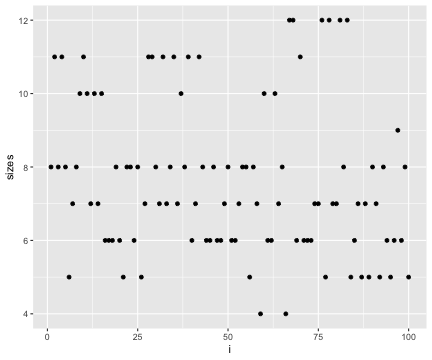

RObject{VecSxp}


In [9]:
szs = map(1:100) do i
    eg = reshape(h5read(out_file, "/eigenvector$i"), 9, :)
    aggs = h5read(f, "0/agg_1")
    scale = h5read(f, "$iter/scale")
    # TODO: I am not sure if this scaling is correct
    eg = eg .* scale
    count(aggs[findmax(mapslices(norm, eg, dims=1)[:])[2]] .== aggs)
end
# TODO: calculate diameter
df = DataFrame(i=1:length(szs), sizes=szs)
display(R"ggplot($df,aes(x=i,y=sizes)) + geom_point()")
#count(map(x -> count(x.==aggs),unique(aggs)) .== 8)

In [10]:
idx = aggs .== topagg
v = vis2[idx, idx];
display("Normalized visibility")
display(Matrix(vis[idx,idx]))
display("Visibility")
display(Matrix(vis2[idx,idx]))
c = eg[:, idx]
u = svd(c).U[:,1]
display("Primary eigenvalue direction")
display(u)
dir = mapslices(s -> dot(s,u), c, dims=1)[:]
display("Portion in primary direction")
display(dir)
#s = gplot(v; vertexcolors=dir)
s = gplot3d(v, poses[:,idx]; vertexcolors=dir)

obs = map(x -> map(y -> y[1], x), ba.observations[p][idx])
pidx = unique(vcat(obs...))
scatter!(s, ba.points[pidx], transparency=true)

centers = mapslices(x -> BALUtils.center(BALUtils.Camera(x)), poses, dims=1)
lines = mapreduce(hcat, enumerate(obs)) do (i,o)
    mapreduce(hcat, o) do oi
        hcat(centers[:,idx][:,i],ba.points[oi])
    end
end
#linesegments!(s, lines[1,:], lines[2,:], lines[3,:])

display(s)

"Normalized visibility"

8×8 Array{Float64,2}:
 1.0       1.0       1.0       1.0       …  0.894427  0.894427  0.5     
 1.0       1.0       1.0       1.0          0.894427  0.894427  0.5     
 1.0       1.0       1.0       1.0          0.894427  0.894427  0.5     
 1.0       1.0       1.0       1.0          0.894427  0.894427  0.5     
 1.0       1.0       1.0       1.0          0.894427  0.894427  0.5     
 0.894427  0.894427  0.894427  0.894427  …  1.0       0.8       0.67082 
 0.894427  0.894427  0.894427  0.894427     0.8       1.0       0.447214
 0.5       0.5       0.5       0.5          0.67082   0.447214  1.0     

"Visibility"

8×8 Array{Int64,2}:
 4  4  4  4  4  4  4  2
 4  4  4  4  4  4  4  2
 4  4  4  4  4  4  4  2
 4  4  4  4  4  4  4  2
 4  4  4  4  4  4  4  2
 4  4  4  4  4  5  4  3
 4  4  4  4  4  4  5  2
 2  2  2  2  2  3  2  4

"Primary eigenvalue direction"

9-element Array{Float64,1}:
 -0.039083199019585346 
 -0.002933895683945749 
 -0.9981228401606826   
 -0.002034039892376586 
 -0.04593803783486722  
  0.009883823282684095 
 -0.001219512423774039 
 -0.0010343272617152237
 -6.415265258304749e-5 

"Portion in primary direction"

8-element Array{Float64,1}:
  -5.832271483191155   
  14.194457406349882   
  -0.9889662755586839  
   9.785964810961019   
 -17.37631566802908    
   0.2241179714718675  
  -0.02497285505250087 
   0.017986093048732686

GLMakie.Screen(...)

In [11]:
mean(map(x->count(x.==aggs), unique(aggs)))

3.173968253968254